In [24]:
import qiskit.qasm2
import os
import time
import pandas as pd

from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import SabreSwap, ApplyLayout, TrivialLayout, EnlargeWithAncilla, FullAncillaAllocation
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from algorithm.sabre import OriginalSabreSwap

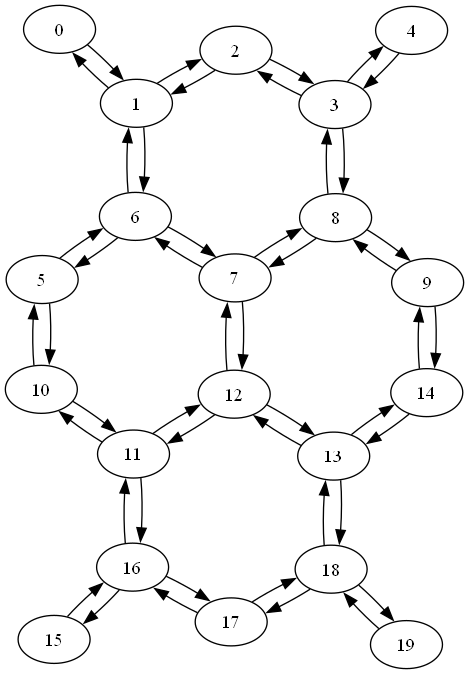

In [25]:
# Import Target provider
provider = FakeAlmadenV2()
coupling_map = CouplingMap(provider.configuration().coupling_map)

coupling_map.draw()

In [26]:
# Set up the pass manager

# Apply the SabreSwap
sabre_pass_manager = PassManager([
    TrivialLayout(coupling_map), # Using TrivialLayout as a starting point
    FullAncillaAllocation(coupling_map), # Allocate ancilla qubits for putting in the sabre swap
    EnlargeWithAncilla(), # Enlarge the circuit with ancilla qubits
    ApplyLayout(), # Apply the layout to the circuit
    OriginalSabreSwap(coupling_map),
])

# Apply the LightweightSabreSwap
light_sabre_pass_manager = PassManager([
    TrivialLayout(coupling_map), # Using TrivialLayout as a starting point
    FullAncillaAllocation(coupling_map), # Allocate ancilla qubits for putting in the sabre swap
    EnlargeWithAncilla(), # Enlarge the circuit with ancilla qubits
    ApplyLayout(), # Apply the layout to the circuit
    SabreSwap(coupling_map),
])

# Not applying the SabreSwap
original_pass_manager = PassManager([
    TrivialLayout(coupling_map), # Using TrivialLayout as a starting point
    FullAncillaAllocation(coupling_map), # Allocate ancilla qubits for putting in the sabre swap
    EnlargeWithAncilla(), # Enlarge the circuit with ancilla qubits
    ApplyLayout(), # Apply the layout to the circuit
])

In [29]:
data_path = '../data'
file_list = os.listdir(data_path)
file_list = [f for f in file_list if f.endswith('.qasm')]

paper_file_list = [
    '4mod5-v1_22.qasm',
    'mod5mils_65.qasm',
    'alu-v0_27.qasm',
    'decod24-v2_43.qasm',
    '4gt13_92.qasm',
    'ising_model_10.qasm',
    'ising_model_13.qasm',
    'ising_model_16.qasm',
    'qft_10.qasm',
    'qft_13.qasm',
    'qft_16.qasm',
    'qft_20.qasm',
    'rd84_142.qasm',
    'adr4_197.qasm',
    'radd_250.qasm',
    'z4_268.qasm',
    'sym6_145.qasm',
    'misex1_241.qasm',
    'rd73_252.qasm',
    'cycle10_2_110.qasm',
    'square_root_7.qasm',
    'sqn_258.qasm',
    'rd84_253.qasm',
    'co14_215.qasm',
    'sym9_193.qasm',
    '9symml_195.qasm',
]
paper_file_list = [file for file in file_list if file in paper_file_list]
file_list = [f for i, f in enumerate(file_list) if i % 5 == 0]
print(len(file_list))





32


In [30]:
df = pd.DataFrame(columns=['file', 'lightweight_execution_time', 'lightweight_number_of_swap', 'original_execution_time', 'original_number_of_swap'])

for file in paper_file_list:
    circuit = qiskit.qasm2.load(os.path.join(data_path, file))

    # original circuit
    original_circuit = original_pass_manager.run(circuit)

    # transpiled circuit with the LightweightSabreSwap
    lightweight_execution_time = time.time()
    lightweight_sabre_circuit = light_sabre_pass_manager.run(circuit)
    lightweight_execution_time = time.time() - lightweight_execution_time
    lightweight_number_of_swap = lightweight_sabre_circuit.size() - original_circuit.size()

    # transpiled circuit with the OriginalSabreSwap
    original_execution_time = time.time()
    original_sabre_circuit = sabre_pass_manager.run(circuit)
    original_execution_time = time.time() - original_execution_time
    original_number_of_swap = original_sabre_circuit.size() - original_circuit.size()

    # Append the results to the DataFrame
    df.loc[len(df)] = [file, lightweight_execution_time, lightweight_number_of_swap, original_execution_time, original_number_of_swap]

# Save the DataFrame to a CSV file
df.to_csv('sabre_swap_results.csv', index=False)